In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

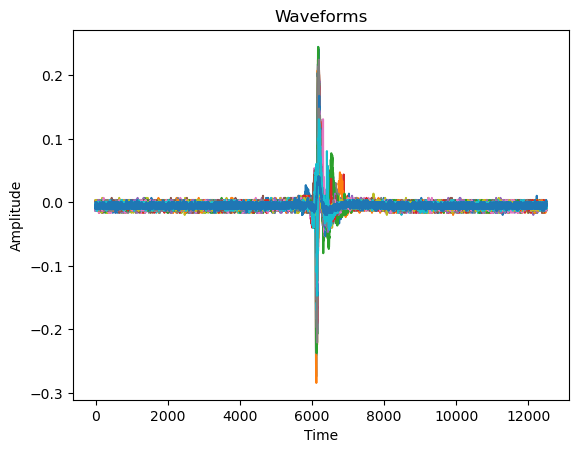

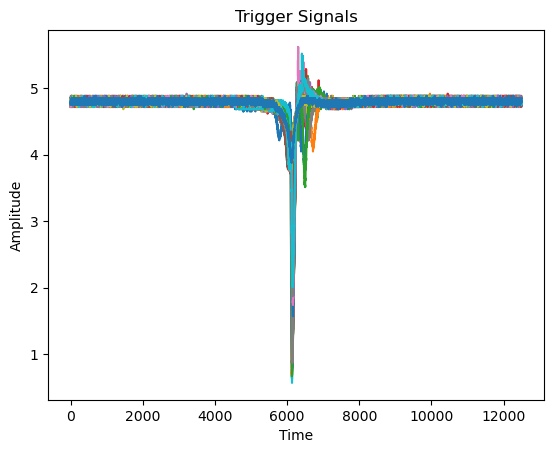

In [5]:
def read_data(filename, seg_len):
    filepath = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/MPhys Sem 1 SiPM-Scintillation (KeySight Oscilloscope)/"
    data = np.genfromtxt(filepath + filename, delimiter=',', skip_header=3)
    n_segs = len(data) // seg_len

    waveforms = np.zeros((n_segs, seg_len, 3))
    for i in range(n_segs):
        waveforms[i] = data[i*seg_len:(i+1)*seg_len]

    np.nan_to_num(waveforms[:,:,2], copy=False, nan=0)

    for waveform in waveforms:
        #waveform[:,2] += np.abs(np.min(waveform[:,2]))
        plt.plot(waveform[:, 2])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Waveforms")
    #plt.xlim(5800,6400)
    plt.show()

    for waveform in waveforms:
        plt.plot(waveform[:, 1])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Trigger Signals")
    #plt.xlim(5800,6400)
    plt.show()

    return waveforms, n_segs

waveforms, n_segs = read_data("55V_1200V_Ar_filter.csv", 12500)

12500


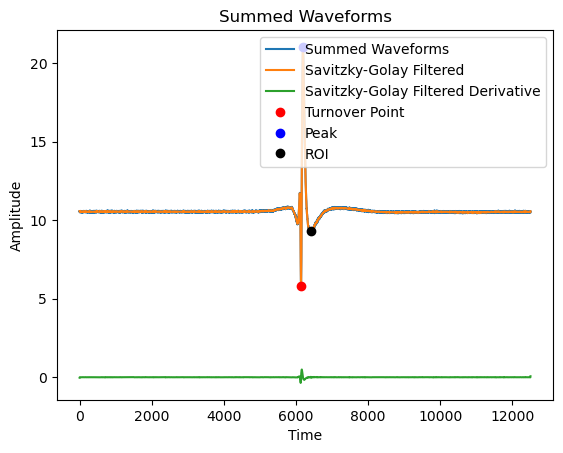

In [10]:
def find_roi(waveforms, n_segs, plot=False):

    for waveform in waveforms:
        waveform[:,2] += np.abs(np.min(waveform[:,2]))

    if plot==True:
        for i in range(n_segs):
            plt.plot(waveforms[i,:,2])
            plt.show()

    waveforms_sum = np.sum(waveforms, axis=0)
    savgol_filtered = savgol_filter(waveforms_sum[:, 2], 60, 9)
    savgol_filtered_deriv = savgol_filter(waveforms_sum[:, 2], 60, 9, deriv=1)

    print(len(savgol_filtered))

    turnover_point = np.argmin(np.abs(savgol_filtered_deriv[np.argmin(savgol_filtered_deriv):np.argmax(savgol_filtered_deriv)])) + np.argmin(savgol_filtered_deriv)
    peak = np.argmax(savgol_filtered)
    roi = [turnover_point, peak+4*(peak-turnover_point)]

    plt.plot(waveforms_sum[:, 2], label="Summed Waveforms")
    plt.plot(savgol_filtered, label="Savitzky-Golay Filtered")
    plt.plot(savgol_filtered_deriv, label="Savitzky-Golay Filtered Derivative")
    plt.plot(turnover_point, savgol_filtered[turnover_point], 'ro', label="Turnover Point")
    plt.plot(peak, savgol_filtered[peak], 'bo', label="Peak")
    plt.plot(roi[1], savgol_filtered[roi[1]], 'ko', label="ROI")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Summed Waveforms")
    plt.legend()
    #plt.xlim(2000,12000)
    #plt.ylim(-0.01, 0.01)
    plt.show()

    return turnover_point, peak

start, peak = find_roi(waveforms, n_segs, plot=False)

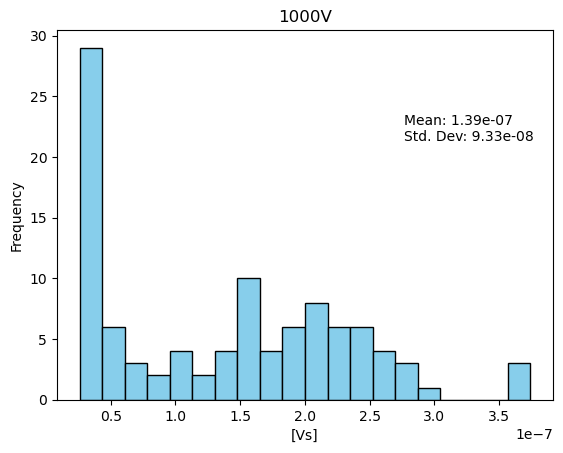

[3.049372476168202e-08,
 2.811581674230695e-07,
 2.2584101096253396e-07,
 2.0336067556430053e-07,
 1.9673975486786684e-07,
 3.54142269993261e-08,
 1.6025439809601726e-07,
 2.9375733102538188e-08,
 3.289707211303971e-08,
 1.897171604967944e-07,
 3.1598327308580235e-08,
 2.883347366953006e-08,
 7.545439557345453e-08,
 2.6698578207116954e-07,
 2.039297132008378e-07,
 1.8430126076106844e-07,
 1.1406862266211804e-07,
 1.496100462797802e-07,
 1.065305471366644e-07,
 3.479832740806193e-08,
 2.5160837579693714e-07,
 1.5351966990965923e-07,
 2.5894561453420618e-08,
 1.6843515152262132e-07,
 2.003949851025788e-07,
 4.432468753009434e-08,
 2.294359901006192e-07,
 9.785439626153379e-08,
 1.5758326829162318e-07,
 3.742928982209905e-07,
 3.530711403128664e-08,
 3.6329373475850065e-07,
 2.7938410879996145e-07,
 6.058577590963329e-08,
 3.3312134890923326e-08,
 2.951029378022967e-07,
 3.000502181493146e-08,
 2.2375900251965277e-07,
 2.0864268409680807e-07,
 3.4684519900111484e-08,
 1.3072469010210698e-

In [11]:
def integrate(waveforms, n_segs, start, peak):
    areas = []  # Store the area for each waveform

    for i in range(n_segs):
        # Extract x and y data for the current waveform
        x_data = waveforms[i, :, 0]
        y_data = waveforms[i, :, 2]

        end = np.argmin(np.abs(y_data[peak:] - y_data[peak]/10)) + peak

        area = 0
        for j in range(int(end-start)):
            area += (x_data[j+start+1] - x_data[j+start]) * (y_data[j+start] + y_data[j+start+1]) / 2
        
        areas.append(area)

        # Optional: Plot individual fits (uncomment for debugging)
        # fitted_peak = emg(x_data, *params)
        #plt.plot(x_data, y_data, '.', label="Noisy Data")
        #plt.plot(x_data[start], y_data[start], 'ro', label="Start")
        #plt.plot(x_data[peak], y_data[peak], 'bo', label="Peak")
        #plt.plot(x_data[end], y_data[end], 'ko', label="End")
        #plt.legend()
        #plt.show()
    
    mean = np.mean(areas)
    std_dev = np.std(areas)

    # Plot a histogram of the areas
    plt.hist(areas, bins=20, color='skyblue', edgecolor='black')
    plt.title("1000V")
    plt.xlabel("[Vs]")
    plt.ylabel("Frequency")
    plt.annotate(f"Mean: {mean:.2e}\nStd. Dev: {std_dev:.2e}", xy=(0.7, 0.7), xycoords='axes fraction')
    plt.show()

    return areas

integrate(waveforms, n_segs, start, peak)